Omar Mancilla Martínez

# Proyecto Final: 

### Objetivos:

- pronosticar la tasa de cancelación de clientes
- generar un modelo que prediga que clientes planean abanoar el servicio
    - Determinar la curva AUC-ROC de dicho modelo
    - Determinar la exactitud del modelo

## Plan de Trabajo
Plan de trabajo para el proyecto final de Tripleten.

## EDA
Iniciamos con la un análisis exploratorio de los datos para entender la información que tenemos y determinar el plan a seguir.

Objetivos del EDA: 
- Entender las cuatro fuentes de datos que tenemos.
- Revisar la calidad de las fuentes de datos
- Generar un diccionario de datos
- Determinar que pre-procesamiento es necesario
- Encontrar tendencias generales en los datos
- Determinar el desbalance de clases


### Carga de datos:
Cargaremos las librerias pertinentes y los datos en archivos CSV.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from boruta import BorutaPy
from imblearn.over_sampling import SMOTE

from scipy.stats import uniform
from scipy.stats import randint
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import sklearn.metrics as metrics

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier


from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score


In [2]:
df_personal = pd.read_csv("./datasets/personal.csv")
df_phone = pd.read_csv("./datasets/phone.csv ")
df_contract = pd.read_csv("./datasets/contract.csv")
df_internet = pd.read_csv("./datasets/internet.csv")

Ahora exploraremos los dataframes a traves de las siguientes funciones:

In [3]:
def explore(df):
    display(df.head())
    print(df.info())
    print("\n shape:", df.shape)
    display(df.describe())
    print("Cantidad de datos nulos:\n", df.isnull().sum(), "\n")

    print("Valores comunes:")
    for columna in df.columns:
        print(f"Valores más comunes en la columna '{columna}':")
        print(df[columna].value_counts())

In [4]:

def plot_raincloud(df):
    # Verify all columns are numeric
    if not all(pd.api.types.is_numeric_dtype(df[col]) for col in df.columns):
        raise ValueError(
            "All columns in the DataFrame must be numeric to create a raincloud plot.")

    fig, ax = plt.subplots(figsize=(8, 4))

    # Iterate over each column in the DataFrame and create a raincloud plot
    for idx, (column, data) in enumerate(df.items()):
        # Boxplot for each feature
        bp = ax.boxplot([data], patch_artist=True,
                        vert=False, positions=[idx + 1])
        bp['boxes'][0].set_facecolor(
            'yellowgreen' if idx % 2 == 0 else 'olivedrab')
        bp['boxes'][0].set_alpha(0.4)

        # Violin plot for each feature
        vp = ax.violinplot([data], points=500, showmeans=False, showextrema=False,
                           showmedians=False, vert=False, positions=[idx + 1])
        vp['bodies'][0].get_paths()[0].vertices[:, 1] = np.clip(
            vp['bodies'][0].get_paths()[0].vertices[:, 1], idx + 1, idx + 2)
        vp['bodies'][0].set_color('thistle' if idx % 2 == 0 else 'orchid')

        # Scatter plot for each feature with jitter
        y = np.full(len(data), idx + 1) + \
            np.random.uniform(low=-0.05, high=0.05, size=len(data))
        ax.scatter(data, y, s=0.3, c='tomato' if idx %
                   2 == 0 else 'darksalmon')

    ax.set_yticks(np.arange(1, len(df.columns) + 1))
    ax.set_yticklabels(df.columns)
    plt.xlabel('Values')
    plt.title("Raincloud plot")
    plt.show()

#### Personal:

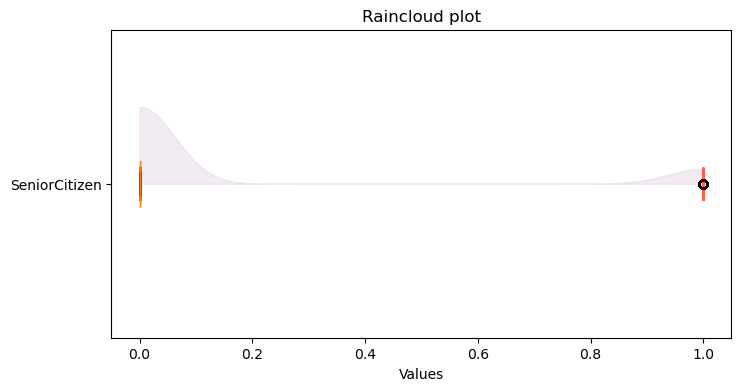

In [5]:
plot_raincloud(pd.DataFrame(df_personal["SeniorCitizen"]))

In [6]:
explore(df_personal)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None

 shape: (7043, 5)


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


Cantidad de datos nulos:
 customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64 

Valores comunes:
Valores más comunes en la columna 'customerID':
customerID
7590-VHVEG    1
3791-LGQCY    1
6008-NAIXK    1
5956-YHHRX    1
5365-LLFYV    1
             ..
9796-MVYXX    1
2637-FKFSY    1
1552-AAGRX    1
4304-TSPVK    1
3186-AJIEK    1
Name: count, Length: 7043, dtype: int64
Valores más comunes en la columna 'gender':
gender
Male      3555
Female    3488
Name: count, dtype: int64
Valores más comunes en la columna 'SeniorCitizen':
SeniorCitizen
0    5901
1    1142
Name: count, dtype: int64
Valores más comunes en la columna 'Partner':
Partner
No     3641
Yes    3402
Name: count, dtype: int64
Valores más comunes en la columna 'Dependents':
Dependents
No     4933
Yes    2110
Name: count, dtype: int64


##### Observaciones:
- Notamos que no tenemos valores nulos en el dataframe
- podemos codificar la mayoria de las columnas, pues son binarias. Como "gender", "partner", "seniorCitizen", 
- Solo el 16% son senior, segun SeniorCitizen

#### Contract:

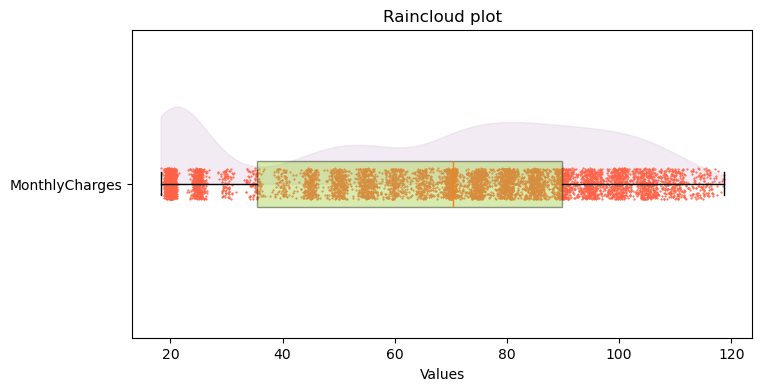

In [7]:
plot_raincloud(pd.DataFrame(df_contract["MonthlyCharges"]))

In [8]:
explore(df_contract)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None

 shape: (7043, 8)


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


Cantidad de datos nulos:
 customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64 

Valores comunes:
Valores más comunes en la columna 'customerID':
customerID
7590-VHVEG    1
3791-LGQCY    1
6008-NAIXK    1
5956-YHHRX    1
5365-LLFYV    1
             ..
9796-MVYXX    1
2637-FKFSY    1
1552-AAGRX    1
4304-TSPVK    1
3186-AJIEK    1
Name: count, Length: 7043, dtype: int64
Valores más comunes en la columna 'BeginDate':
BeginDate
2014-02-01    366
2019-10-01    237
2019-11-01    237
2019-09-01    237
2020-01-01    233
             ... 
2020-02-01     11
2014-01-01      7
2013-10-01      3
2013-12-01      3
2013-11-01      2
Name: count, Length: 77, dtype: int64
Valores más comunes en la columna 'EndDate':
EndDate
No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name:

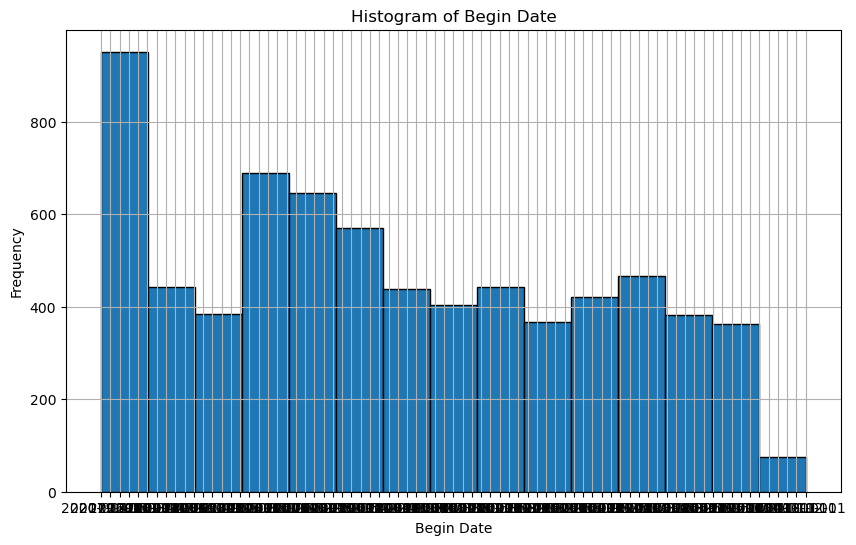

In [9]:
df_contract["BeginDate"].hist(bins=15, edgecolor='black', figsize=(10, 6))
plt.xlabel('Begin Date')
plt.ylabel('Frequency')
plt.title('Histogram of Begin Date')
plt.show()


##### Observaciones:
- Las columnas de fechas tienen un tipo incorrecto.
- ```TotalCharges``` tiene el tipo incorrecto y contiene valores invalidos ```" "```.
- ```Type,	PaperlessBilling,	PaymentMethod``` pueden ser codificados.
- ```MonthlyCharges``` parece estar distribuido de forma normal.
- ```EndDate``` usa "NO" para seleccionar clientes que no han terminado su contrato, evitando poder usar el formato correcto.
- De ```BegingDate``` se tiene que extraer la información relevante, para que pueda ser usada por lo modelos, se extraera unicamente la antigüedad en meses.

#### Internet:
No usaremos un raincloud plot, pues no hay columnas numericas.

In [10]:
explore(df_internet)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None

 shape: (5517, 8)


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


Cantidad de datos nulos:
 customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64 

Valores comunes:
Valores más comunes en la columna 'customerID':
customerID
7590-VHVEG    1
5181-OABFK    1
9356-AXGMP    1
5176-OLSKT    1
7508-DQAKK    1
             ..
1104-FEJAM    1
2972-YDYUW    1
4238-JSSWH    1
0869-PAPRP    1
3186-AJIEK    1
Name: count, Length: 5517, dtype: int64
Valores más comunes en la columna 'InternetService':
InternetService
Fiber optic    3096
DSL            2421
Name: count, dtype: int64
Valores más comunes en la columna 'OnlineSecurity':
OnlineSecurity
No     3498
Yes    2019
Name: count, dtype: int64
Valores más comunes en la columna 'OnlineBackup':
OnlineBackup
No     3088
Yes    2429
Name: count, dtype: int64
Valores más comunes en la columna 'DeviceProtection':
DeviceProtection
No     3095
Yes    2422
Name: count, dtype: int64
Valor

##### Observaciones:
- No tenemos datos nulos
- Todas las columnas excepto el id de cliente, pueden ser codificadas.

#### Phone:
No crearemos un raincloud plot, pues no hay columnas numericas.

In [11]:
explore(df_phone)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None

 shape: (6361, 2)


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


Cantidad de datos nulos:
 customerID       0
MultipleLines    0
dtype: int64 

Valores comunes:
Valores más comunes en la columna 'customerID':
customerID
5575-GNVDE    1
0980-FEXWF    1
8082-GHXOP    1
3393-FMZPV    1
8701-DGLVH    1
             ..
8197-BFWVU    1
9154-QDGTH    1
8499-BRXTD    1
8552-OBVRU    1
3186-AJIEK    1
Name: count, Length: 6361, dtype: int64
Valores más comunes en la columna 'MultipleLines':
MultipleLines
No     3390
Yes    2971
Name: count, dtype: int64


##### Observaciones:
- No tenemos datos nulos
- La unica columna puede ser codificada.

### Dicciónario de datos:
Con lo explroado podemos generar el siguiente diccionario de datos:

- Personal.csv
    - CustomerID: Identificador unico de cada cliente
    - gender: genero del cliente
    - SeniorCitizen: estado de señoria del cleinte
    - Partner: Estado civil del cliente, yes: casado
    - Dependents: ¿El cliente tiene familia que dependa de el?
- Contract.csv
    - customerID: Identificador unico de cada cliente
    - BeginDate: Fecha en la que se firmo el contrato
    - EndDate: Fecha en la que se abandono el servició, "No" en caso de que no se haya abandonado.
    - Type: tipo de facturación
    - PaperlessBilling: formato de las facturas
    - PaymentMethod: Metodo de pago
    - MonthlyCharges: Cargos mensuales
    - TotalCharges: Cargos totales
- Internet.csv
    - CustomerID: Identificador unico de cada cliente
    - InternetService
    - OnlineSecurity
    - OnlineBackup
    - DeviceProtection
    - TechSupport
    - StreamingTV
    - StreamingMovies
- Phone.cvs
    - CustomerID: Identificador unico de cada cliente
    - MultipleLines: ¿El cliente tiene mas de una linea telefonica?

### Pre-procesamiento:
Aplicamos las observaciones a los respectivos datasets:

#### contract:  
Cambiaremos el formato de las fechas, igualmente cambiaremos "No" para los contratos no terminados, por una fecha futura.

In [12]:
df_contract["BeginDate"] = df_contract["BeginDate"].astype("datetime64[ms]")
df_contract["EndDate"] = (df_contract["EndDate"].replace(
    "No", "2025-01-01")).astype("datetime64[ms]")

Buscamos extraer la antigüedad de "BeginDate" para poder usarla en el modelo, primero buscamos la fecha a partir de la cual se medira la antigüedad:

In [13]:
df_contract["BeginDate"].sort_values().tail()

3331   2020-02-01
6670   2020-02-01
936    2020-02-01
3826   2020-02-01
6754   2020-02-01
Name: BeginDate, dtype: datetime64[ms]

tomaremos la fecha "2020-01-01" como el "presente" a partir del cual se medira la antiguedad:

In [14]:
presente = np.datetime64("2020-01-01", "ms")
df_contract["Antiguedad"] = ((presente - df_contract['BeginDate']).dt.days/30.41).astype("int")
df_contract["Antiguedad"]

0        0
1       33
2        3
3       44
4        4
        ..
7038    22
7039    71
7040    10
7041     6
7042    65
Name: Antiguedad, Length: 7043, dtype: int32

Eliminamos los valores invalidos de "TotalCharges", debido a que solo tenemos 11 entradas y cambiamos el tipo de dato:

In [15]:

df_contract[df_contract["TotalCharges"] == " "].info()
df_contract = df_contract[df_contract["TotalCharges"].replace(
    " ", np.nan).notna()]

<class 'pandas.core.frame.DataFrame'>
Index: 11 entries, 488 to 6754
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        11 non-null     object        
 1   BeginDate         11 non-null     datetime64[ms]
 2   EndDate           11 non-null     datetime64[ms]
 3   Type              11 non-null     object        
 4   PaperlessBilling  11 non-null     object        
 5   PaymentMethod     11 non-null     object        
 6   MonthlyCharges    11 non-null     float64       
 7   TotalCharges      11 non-null     object        
 8   Antiguedad        11 non-null     int32         
dtypes: datetime64[ms](2), float64(1), int32(1), object(5)
memory usage: 836.0+ bytes


In [16]:
df_contract["TotalCharges"] = df_contract["TotalCharges"].astype("float64")
df_contract[df_contract["TotalCharges"] == " "]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Antiguedad


Con esto corroboramos que los datos son correctos:



In [17]:
df_contract.info()
df_contract

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   BeginDate         7032 non-null   datetime64[ms]
 2   EndDate           7032 non-null   datetime64[ms]
 3   Type              7032 non-null   object        
 4   PaperlessBilling  7032 non-null   object        
 5   PaymentMethod     7032 non-null   object        
 6   MonthlyCharges    7032 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   Antiguedad        7032 non-null   int32         
dtypes: datetime64[ms](2), float64(2), int32(1), object(4)
memory usage: 521.9+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Antiguedad
0,7590-VHVEG,2020-01-01,2025-01-01,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,2025-01-01,One year,No,Mailed check,56.95,1889.50,33
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,3
3,7795-CFOCW,2016-05-01,2025-01-01,One year,No,Bank transfer (automatic),42.30,1840.75,44
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,4
...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,2025-01-01,One year,Yes,Mailed check,84.80,1990.50,22
7039,2234-XADUH,2014-02-01,2025-01-01,One year,Yes,Credit card (automatic),103.20,7362.90,71
7040,4801-JZAZL,2019-03-01,2025-01-01,Month-to-month,Yes,Electronic check,29.60,346.45,10
7041,8361-LTMKD,2019-07-01,2019-11-01,Month-to-month,Yes,Mailed check,74.40,306.60,6


### Enriquecimiento de datos:
Crearemos la columna churn en "df_contract", esta columna sera nuestro objetivo en los modelos.


In [18]:
df_contract["churn"] = df_contract["EndDate"].apply(
    lambda x: 1 if x < pd.to_datetime("2025-01-01")
    else 0)

### Dataframe maestro:

Crearemos un dataframe maestro con la intención de juntar la información a trabajar, esto a través de inner joins con el proposito de tener unicamente registros completos.


In [19]:
df_master = df_contract.merge(df_personal, how="inner", on="customerID")
df_master = df_master.merge(df_internet, how="inner", on="customerID")
df_master = df_master.merge(df_phone, how="inner", on="customerID")

df_master

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Antiguedad,churn,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,5575-GNVDE,2017-04-01,2025-01-01,One year,No,Mailed check,56.95,1889.50,33,0,...,No,No,DSL,Yes,No,Yes,No,No,No,No
1,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,3,1,...,No,No,DSL,Yes,Yes,No,No,No,No,No
2,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,4,1,...,No,No,Fiber optic,No,No,No,No,No,No,No
3,9305-CDSKC,2019-03-01,2019-11-01,Month-to-month,Yes,Electronic check,99.65,820.50,10,1,...,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes
4,1452-KIOVK,2018-04-01,2025-01-01,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,21,0,...,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4827,8456-QDAVC,2018-07-01,2025-01-01,Month-to-month,Yes,Bank transfer (automatic),78.70,1495.10,18,0,...,No,No,Fiber optic,No,No,No,No,Yes,No,No
4828,6840-RESVB,2018-02-01,2025-01-01,One year,Yes,Mailed check,84.80,1990.50,22,0,...,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes
4829,2234-XADUH,2014-02-01,2025-01-01,One year,Yes,Credit card (automatic),103.20,7362.90,71,0,...,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
4830,8361-LTMKD,2019-07-01,2019-11-01,Month-to-month,Yes,Mailed check,74.40,306.60,6,1,...,Yes,No,Fiber optic,No,No,No,No,No,No,Yes


In [20]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4832 entries, 0 to 4831
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        4832 non-null   object        
 1   BeginDate         4832 non-null   datetime64[ms]
 2   EndDate           4832 non-null   datetime64[ms]
 3   Type              4832 non-null   object        
 4   PaperlessBilling  4832 non-null   object        
 5   PaymentMethod     4832 non-null   object        
 6   MonthlyCharges    4832 non-null   float64       
 7   TotalCharges      4832 non-null   float64       
 8   Antiguedad        4832 non-null   int32         
 9   churn             4832 non-null   int64         
 10  gender            4832 non-null   object        
 11  SeniorCitizen     4832 non-null   int64         
 12  Partner           4832 non-null   object        
 13  Dependents        4832 non-null   object        
 14  InternetService   4832 n

## Procesamiento para los modelos:

Realizaremos la separación entre caracteristicas y objetivo del dataframe maestro.

### Separación de caracteristicas:
Retiraremos "CustomerID" pues sabemos no es necesario, se filtraran mas caractisticas mas adelante.



In [21]:
features = df_master.drop(["customerID", "churn", "EndDate","BeginDate"], axis=1)
target = df_master["churn"]

### Codificación de caracteristicas:


In [22]:
features_ohe = pd.get_dummies(features, drop_first=True)
features_ohe

,MonthlyCharges,TotalCharges,Antiguedad,SeniorCitizen,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,...,Partner_Yes,Dependents_Yes,InternetService_Fiber optic,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
0,56.95,1889.50,33,0,True,False,False,False,False,True,...,False,False,False,True,False,True,False,False,False,False
1,53.85,108.15,3,0,False,False,True,False,False,True,...,False,False,False,True,True,False,False,False,False,False
2,70.70,151.65,4,0,False,False,True,False,True,False,...,False,False,True,False,False,False,False,False,False,False
3,99.65,820.50,10,0,False,False,True,False,True,False,...,False,False,True,False,False,True,False,True,True,True
4,89.10,1949.40,21,0,False,False,True,True,False,False,...,False,True,True,False,True,False,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4827,78.70,1495.10,18,0,False,False,True,False,False,False,...,False,False,True,False,False,False,False,True,False,False
4828,84.80,1990.50,22,0,True,False,True,False,False,True,...,True,True,False,True,False,True,True,True,True,True
4829,103.20,7362.90,71,0,True,False,True,True,False,False,...,True,True,True,False,True,True,False,True,True,True
4830,74.40,306.60,6,1,False,False,True,False,False,True,...,True,False,True,False,False,False,False,False,False,True


In [23]:
features_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4832 entries, 0 to 4831
Data columns (total 21 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   MonthlyCharges                         4832 non-null   float64
 1   TotalCharges                           4832 non-null   float64
 2   Antiguedad                             4832 non-null   int32  
 3   SeniorCitizen                          4832 non-null   int64  
 4   Type_One year                          4832 non-null   bool   
 5   Type_Two year                          4832 non-null   bool   
 6   PaperlessBilling_Yes                   4832 non-null   bool   
 7   PaymentMethod_Credit card (automatic)  4832 non-null   bool   
 8   PaymentMethod_Electronic check         4832 non-null   bool   
 9   PaymentMethod_Mailed check             4832 non-null   bool   
 10  gender_Male                            4832 non-null   bool   
 11  Part

### Balanceo de clases:

In [24]:
target.value_counts()

churn
0    3246
1    1586
Name: count, dtype: int64

Podemos ver que hay un desbalance de clases de alrededor de 65-35.

Balancearemos la cantidad de clases usando SMOTE

In [25]:

y = target
X = features_ohe

# Aplicar SMOTE para balancear las clases
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

features_ohe_resampled = pd.DataFrame(X_resampled, columns=X.columns)

target_resampled = y_resampled

# Revisar la distribución de las clases después de aplicar SMOTE
print("Distribución de clases después de SMOTE:")
print(target_resampled.value_counts())

Distribución de clases después de SMOTE:
churn
0    3246
1    3246
Name: count, dtype: int64


In [26]:
features_ohe_resampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6492 entries, 0 to 6491
Data columns (total 21 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   MonthlyCharges                         6492 non-null   float64
 1   TotalCharges                           6492 non-null   float64
 2   Antiguedad                             6492 non-null   int32  
 3   SeniorCitizen                          6492 non-null   int64  
 4   Type_One year                          6492 non-null   bool   
 5   Type_Two year                          6492 non-null   bool   
 6   PaperlessBilling_Yes                   6492 non-null   bool   
 7   PaymentMethod_Credit card (automatic)  6492 non-null   bool   
 8   PaymentMethod_Electronic check         6492 non-null   bool   
 9   PaymentMethod_Mailed check             6492 non-null   bool   
 10  gender_Male                            6492 non-null   bool   
 11  Part

### Escalado de caracteristicas
Debido a que evaluaremos con cross validation, el escalado se hara dentro de cada "pliegue" del dataset TV a través de pipelines, esto para evitar data leakage.

Sin embargo, esto se debe aplicar unicamente a nuestras caracteristicas numericas, por lo que tambien tenemos que definir un pre procesador que sera usado en el pipeline:

In [27]:
def create_preprocessor(df):
    numeric_features = df.select_dtypes(include=['number']).columns
    categorical_features = df.select_dtypes(exclude=['number']).columns

    numeric_indices = [df.columns.get_loc(col) for col in numeric_features]
    categorical_indices = [df.columns.get_loc(col) for col in categorical_features]

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_indices),  # Escala las columnas numéricas usando sus índices
            ('cat', 'passthrough', categorical_indices)   # Deja las columnas categóricas sin cambios usando sus índices
        ]
    )

    return preprocessor


In [28]:
'''
numeric_features = features_ohe_resampled.select_dtypes(include=['number']).columns
categorical_features = features_ohe_resampled.select_dtypes(exclude=['number']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),  # Escala las columnas numéricas
        ('cat', 'passthrough', categorical_features)  # Deja las columnas categóricas sin cambios
    ]
)
'''

"\nnumeric_features = features_ohe_resampled.select_dtypes(include=['number']).columns\ncategorical_features = features_ohe_resampled.select_dtypes(exclude=['number']).columns\n\npreprocessor = ColumnTransformer(\n    transformers=[\n        ('num', StandardScaler(), numeric_features),  # Escala las columnas numéricas\n        ('cat', 'passthrough', categorical_features)  # Deja las columnas categóricas sin cambios\n    ]\n)\n"

In [29]:
def create_pipeline(model_class,df=features_ohe_resampled):
    pipeline = Pipeline([
        ('preprocessor', create_preprocessor(df)),  # Preprocesa las columnas según su tipo
        ('model', model_class)  # Instancia del modelo
    ])
    return pipeline

### Selección de caracteristicas:
Usaremos boruta junto con un bosque aleatorio para seleccionar las caracteristicas relevantes para los modelos, esto con el fin de disminuir la carga computacional y reducir el tiempo de ejecución:

In [30]:
X = (features_ohe_resampled).values
y = target_resampled.values
y = y.ravel()

rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)

# find all relevant features - 5 features should be selected
feat_selector.fit(X, y)

# check selected features - first 5 features are selected
feat_selector.support_

# check ranking of features
feat_selector.ranking_

# call transform() on X to filter it down to selected features
features_selected = feat_selector.transform(X)


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	15
Tentative: 	2
Rejected: 	4
Iteration: 	9 / 100
Confirmed: 	15
Tentative: 	2
Rejected: 	4
Iteration: 	10 / 100
Confirmed: 	15
Tentative: 	2
Rejected: 	4
Iteration: 	11 / 100
Confirmed: 	15
Tentative: 	2
Rejected: 	4
Iteration: 	12 / 100
Confirmed: 	16
Tentative: 	1
Rejected: 	4
Iteration: 	13 / 100
Confirmed: 	16
Tentative: 	1
Rejected: 	4
Iteration: 	14 / 100
Confirmed: 	16
Tentative: 	1
Rejected: 	4
Iteration: 	15 / 100
Confirmed: 	16
Tentative: 	1
Rejected: 	4
Iteration: 	16 / 100
Confirmed: 	16
Tentative: 	1
Rejected: 	4
I

In [31]:
features_selected.shape

(6492, 17)

In [32]:
features_selected=pd.DataFrame(features_selected)
display(features_selected)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,56.95,1889.5,33,True,False,False,False,False,True,True,False,True,False,False,False,False,False
1,53.85,108.15,3,False,False,True,False,False,True,True,False,True,True,False,False,False,False
2,70.7,151.65,4,False,False,True,False,True,False,False,True,False,False,False,False,False,False
3,99.65,820.5,10,False,False,True,False,True,False,False,True,False,False,False,True,True,True
4,89.1,1949.4,21,False,False,True,True,False,False,True,True,False,True,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6487,88.284217,1264.519301,14,False,False,True,False,False,False,False,True,False,True,False,False,True,True
6488,84.459653,412.005645,7,False,False,True,False,True,True,False,True,False,True,False,True,True,False
6489,81.58057,3179.677942,40,True,False,True,True,True,False,True,True,True,False,True,True,True,True
6490,90.449205,4340.901817,50,False,False,True,False,True,False,True,True,True,True,False,True,True,True


Boruta ha seleccionado 16 caracteristicas de las 21 para el modelo.

Procederemos a graficar la importancia de las caracteristicas en un bosque de decición:

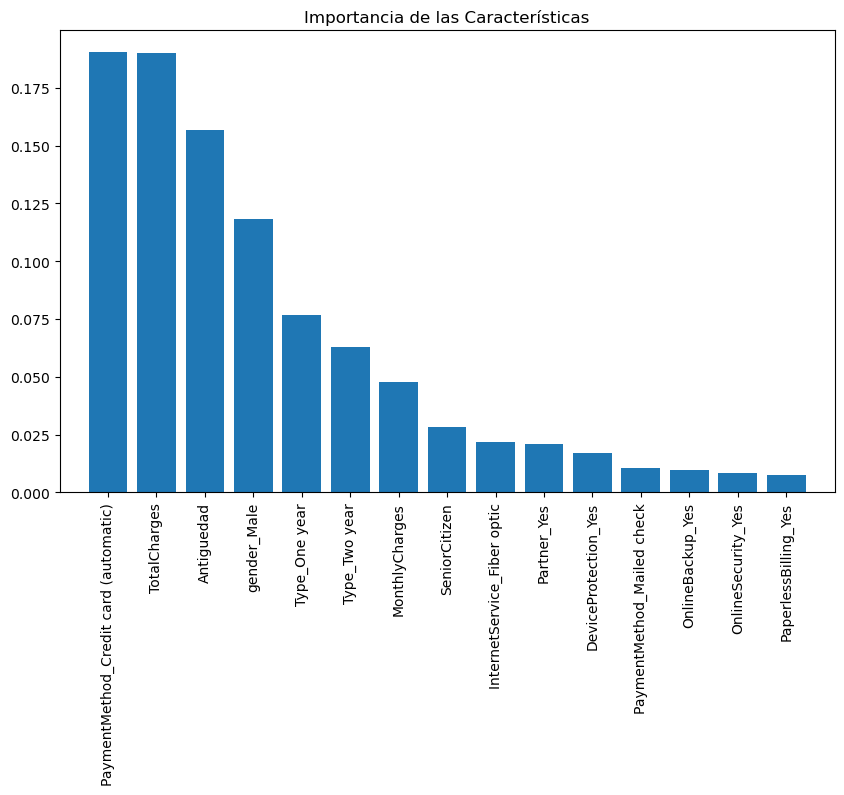

In [33]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

feature_names = features_ohe_resampled.columns

n = 15
plt.figure(figsize=(10, 6))

plt.title("Importancia de las Características")


plt.bar(range(n), importances[indices[:n]])
plt.xticks(range(n), feature_names[indices[:n]], rotation=90)
plt.xlim([-1, n])
plt.show()

Observacuiones:
- Boruta selecciono diez caracteristicas.
- La importancia de las caracteristicas disminuye a la mitad a partir de la cuarta caracteristica, asi que consideramos la decisión de boruta apropiada.

### División del dataset:
Dividiremos el dataset en dos partes:
- Train & validtion (TV) 90%
- Test 10%

Esto debido a que usaremos cross validation en los modelos para evaluar de forma robusta.


In [34]:
TV_features, test_features, TV_target, test_target = train_test_split(
    features_selected, target_resampled, test_size=0.1, random_state=42
)

## Analisís de los datos:

A partir de ahora desarrollaremos los modelos de ML con las caracteristicas trabajadas hasta ahora.
Aqui comienza la solución de la asignación principal:


### Generar modelos de Machine Learning:
Generaremos seis modelos, estos sera, evaluados a través de cross validation usando los dataframe de entrenamiento  y validacion (TV): "TV_features" y "TV_target". 

Para este objetivo usaremos la siguiente función que hace uso de randomizedSearchCV junto el pipeline creado y una función de evaluación:




In [35]:
def random_search_train(model_class,param_dist):
    random_search = RandomizedSearchCV (estimator=create_pipeline(model_class(),TV_features), param_distributions=param_dist, cv= 5, n_jobs=-1, scoring='roc_auc',verbose=0)
    random_search.fit(TV_features,TV_target)
    best_params = random_search.best_params_
    best_params = {key.split('__')[-1]: value for key, value in best_params.items()}
    display(best_params)
    model=model_class(**best_params)
    best_model =create_pipeline(model,TV_features).fit(TV_features, TV_target)

    return best_model

Donde usaremos la siguiente función para evaluar los modelos usando el set de prueba (test):


In [36]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        #print("eval_stats_Accuaracy:",eval_stats[type]['Accuracy'])
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(3)
    #df_eval_stats = df_eval_stats.reindex(index=('Exactitud', 'F1', 'APS', 'ROC AUC'))
    display(df_eval_stats)
    
    return df_eval_stats

Esta función evalua con cross validatión, a la vez que llama al pipeline de escalado de datos, teniendo un escalado propio en cada sección de la validación cruzada, evitando el data leakage y mateniendo una evaluación robusta.

#### Modelo Dummy:
Aplicamos la función definida en el modelo dummy, el cual usa los target mas frecuentes para hacer sus predicciones:


,train,test
ROC AUC,0.500,0.500
APS,0.499,0.505
Accuracy,0.501,0.495
F1,0.000,0.000


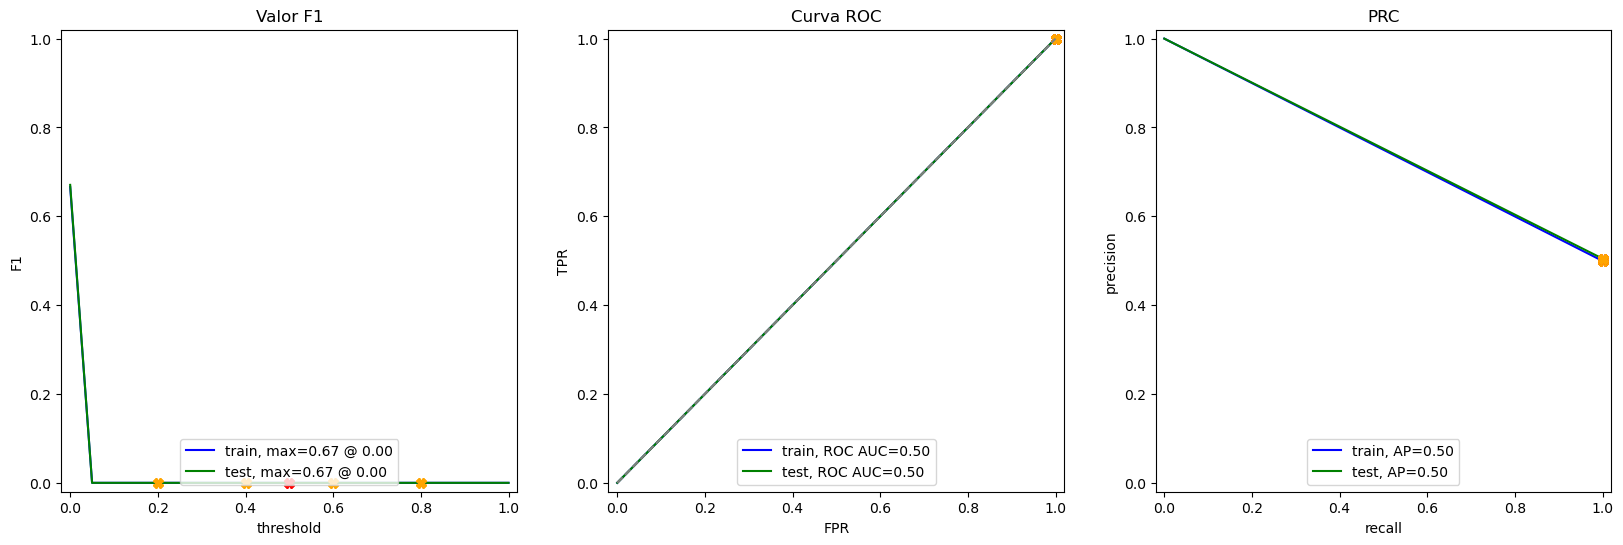

In [56]:
dummy = DummyClassifier(strategy='most_frequent')

dummy_pipeline = create_pipeline(dummy,TV_features).fit(TV_features, TV_target)
eval_dummy=evaluate_model(dummy_pipeline, TV_features, TV_target, test_features, test_target)

Este valor nos sirve como prueba de cordura, para saber si los siguientes modelos son buenos o no.


#### Arbol de decisiones:

Iniciamos creand una distribución de parametros que servira para multiples modelos:




In [38]:
param_dist = {
    'model__max_depth': randint(1, 10),  # Rango de 1 a 7 (inclusive)
    'model__min_samples_split': randint(2, 11),  # Rango de 2 a 10 (inclusive)
    'model__min_samples_leaf': randint(1, 11),  # Rango de 1 a 10 (inclusive)
    'model__criterion': ['gini', 'entropy'],  # Criterios de división
    'model__splitter': ['best', 'random'],  # Estrategia para dividir
    'model__min_impurity_decrease': [0.0, 0.01, 0.1, 0.2],  # Valores posibles para impureza mínima
    'model__max_leaf_nodes': randint(2,30)  # Número máximo de nodos hoja
}


Ahora realizamos una busqueda aleatoria de los mejores hipeparametros en nnuestra distribución:

In [39]:
best_tree=random_search_train(DecisionTreeClassifier,param_dist)

{'criterion': 'entropy',
 'max_depth': 8,
 'max_leaf_nodes': 25,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 7,
 'min_samples_split': 9,
 'splitter': 'best'}

Ahora procederemos a evaluar el modelo obtenido:

,train,test
ROC AUC,0.879,0.870
APS,0.868,0.855
Accuracy,0.792,0.798
F1,0.800,0.809


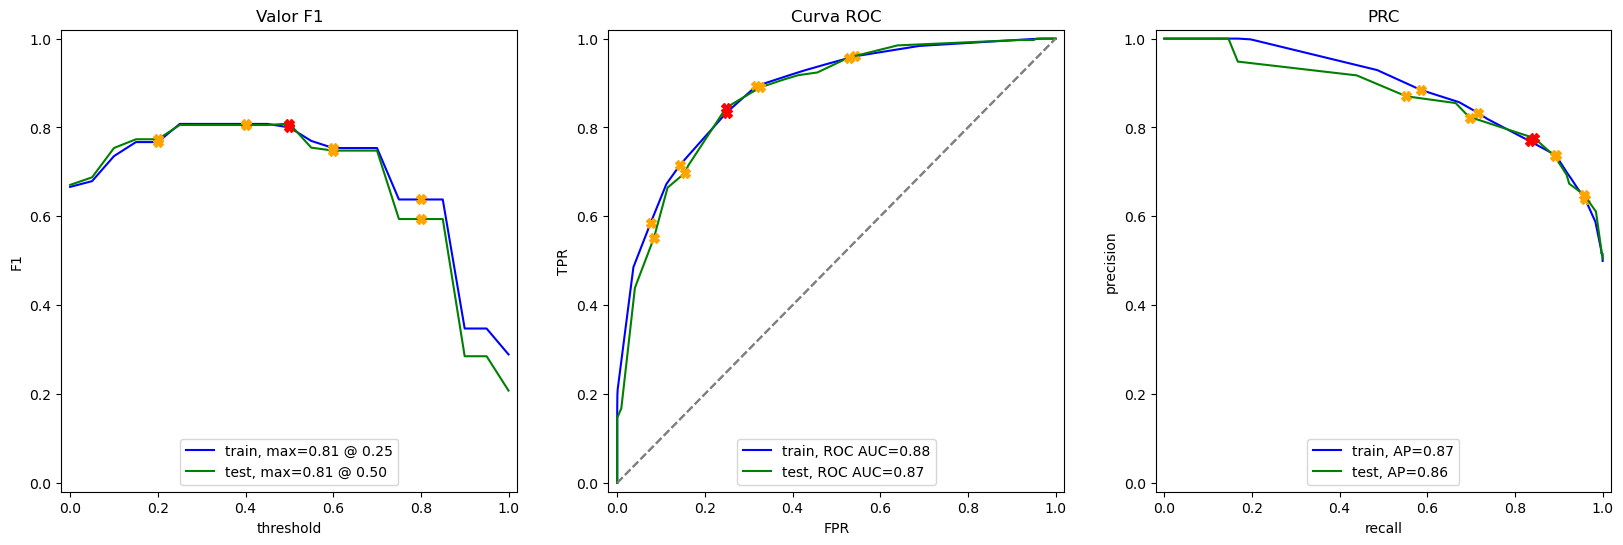

In [40]:
eval_tree=evaluate_model(best_tree, TV_features, TV_target, test_features, test_target)

#### Random Forest:


In [41]:

param_dist = {
    #'model__n_estimators': randint(50, 201),         # Número de árboles en el bosque (entre 50 y 200)
    'model__max_depth': randint(3, 22),               # Profundidad máxima de los árboles (entre 3 y 20)
    'model__min_samples_split': randint(2, 11),       # Mínimo número de muestras para dividir un nodo (entre 2 y 10)
    'model__min_samples_leaf': randint(1, 11),        # Mínimo número de muestras en una hoja (entre 1 y 10)
    'model__criterion': ['gini', 'entropy'],          # Criterio para la división de los nodos
}

In [42]:
best_forest=random_search_train(RandomForestClassifier,param_dist)

{'criterion': 'gini',
 'max_depth': 18,
 'min_samples_leaf': 2,
 'min_samples_split': 4}

,train,test
ROC AUC,0.996,0.934
APS,0.997,0.942
Accuracy,0.964,0.838
F1,0.964,0.838


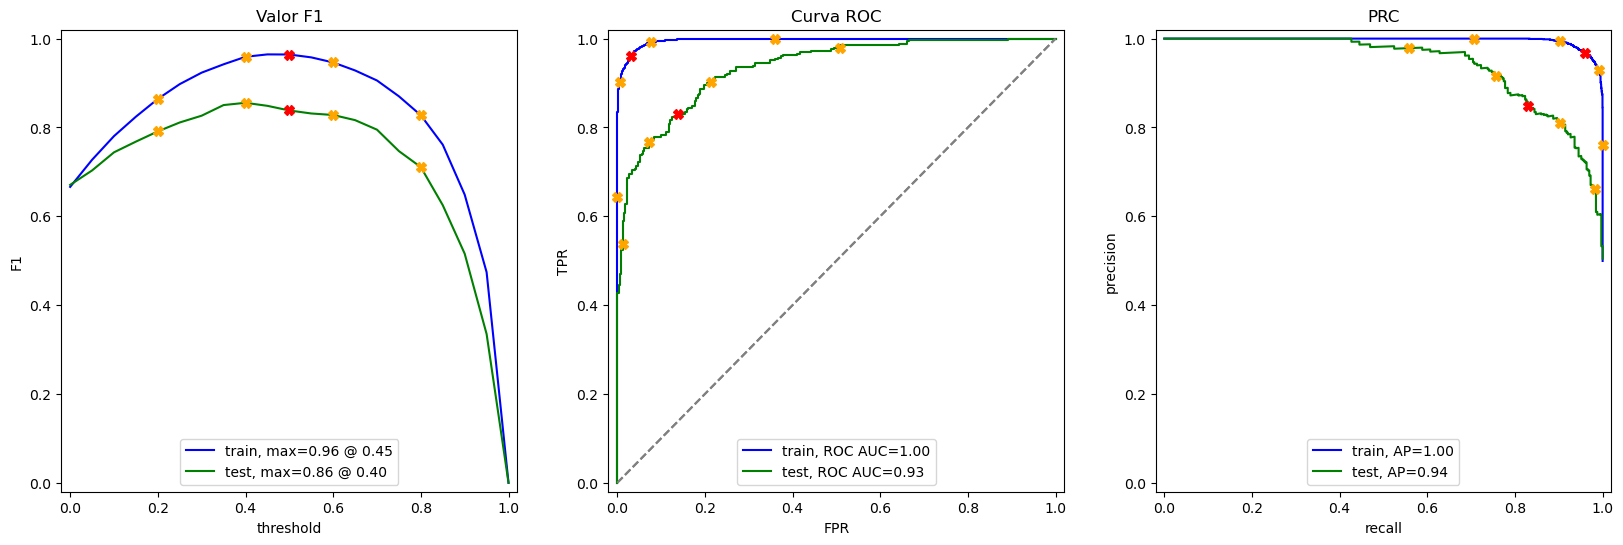

In [43]:
eval_forest=evaluate_model(best_forest, TV_features, TV_target, test_features, test_target)

#### Regresión Logística



,train,test
ROC AUC,0.866,0.860
APS,0.872,0.872
Accuracy,0.777,0.783
F1,0.777,0.787


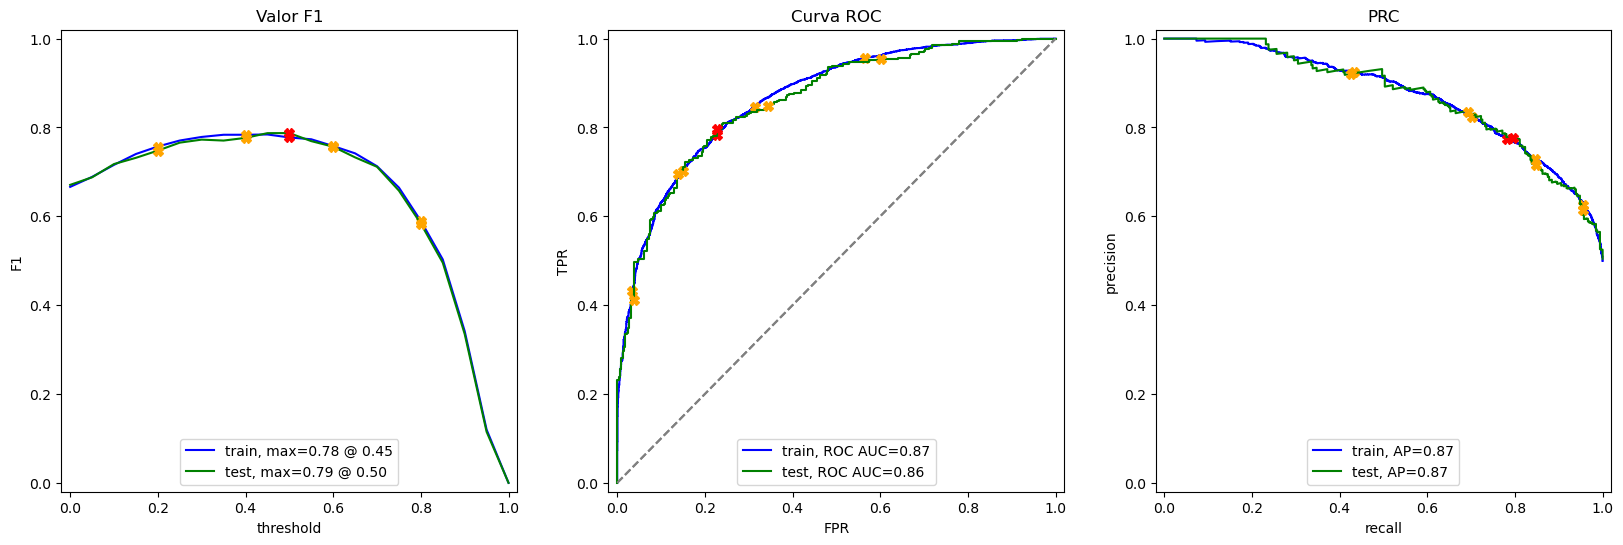

In [57]:
model=LogisticRegression(solver='liblinear')

model_pipeline = create_pipeline(model,TV_features).fit(TV_features, TV_target)
eval_regression=evaluate_model(model_pipeline, TV_features, TV_target, test_features, test_target)

#### Decenso de gradiente (LigthGBM):

In [52]:
param_dist  = {
    'model__n_estimators': randint(50, 300),
    'model__learning_rate': uniform(loc=0.01, scale=0.39), 
    'model__max_depth' : randint(2,11)}

In [54]:
bestLightGBM=random_search_train(LGBMClassifier,param_dist)


[LightGBM] [Info] Number of positive: 2918, number of negative: 2924
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000288 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 614
[LightGBM] [Info] Number of data points in the train set: 5842, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499486 -> initscore=-0.002054
[LightGBM] [Info] Start training from score -0.002054
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

{'learning_rate': 0.22395422603095907, 'max_depth': 5, 'n_estimators': 239}

[LightGBM] [Info] Number of positive: 2918, number of negative: 2924
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 614
[LightGBM] [Info] Number of data points in the train set: 5842, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499486 -> initscore=-0.002054
[LightGBM] [Info] Start training from score -0.002054
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

,train,test
ROC AUC,1.000,0.971
APS,1.000,0.975
Accuracy,0.996,0.905
F1,0.996,0.903


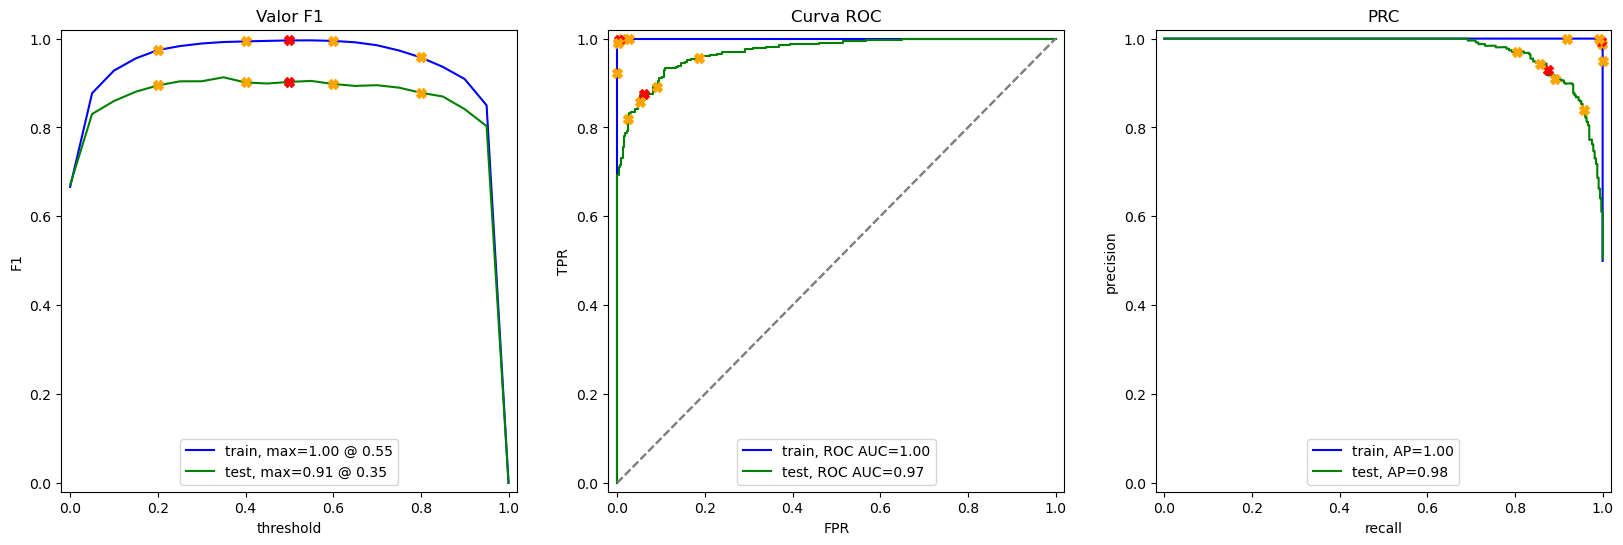

In [55]:
eval_LGBM=evaluate_model(bestLightGBM, TV_features, TV_target, test_features, test_target)

### Analisis de las evaluaciones de los modelos
Compararemos las evaluaciones de los modelos

Enfocandonos unicamente en la metrica ROC AUC del set de prueba y ordenando para su analisis:

In [126]:
evaluations=pd.DataFrame(eval_dummy["test"])
i=0
models=[ eval_tree, eval_forest, eval_regression, eval_LGBM]

for model in models:
    i+=1
    evaluations=evaluations.join(model["test"], rsuffix=i)
evaluations=evaluations.transpose()
new_index=["eval_dummy", "eval_tree", "eval_forest", "eval_regression", "eval_LGBM"]
evaluations.index =new_index
evaluations

,ROC AUC,APS,Accuracy,F1
eval_dummy,0.500,0.505,0.495,0.000
eval_tree,0.870,0.855,0.798,0.809
eval_forest,0.934,0.942,0.838,0.838
eval_regression,0.860,0.872,0.783,0.787
eval_LGBM,0.971,0.975,0.905,0.903


Ahora buscamos unicamente la metrica de interes, el area bajo la curva de la Característica Operativa del Receptor "ROC AUC":

In [131]:
display(pd.DataFrame(evaluations[["ROC AUC","Accuracy"]]).sort_values("ROC AUC", ascending=False))

,ROC AUC,Accuracy
eval_LGBM,0.971,0.905
eval_forest,0.934,0.838
eval_tree,0.870,0.798
eval_regression,0.860,0.783
eval_dummy,0.500,0.495


Notamos que el modelo que mejor se desempeño fue "LightGBM", con un *ROC AUC* de **0.97**, a la vez posee la exactitud mas alta con *0.905*.

## Observaciones y Conclusiones

- Se ha determinado el objetivo del proyecto final
- Se determino un plan general de trabajo
- Se ha realizado un *EDA* exhaustivo de los datos, identificando variables importantes y planificando el preprocesamiento.
- Se realizó el preprocesamiento necesario, junto con un enriquecimiento de datos

- Se realizó un procesamiento de los datos para alimentar los modelos de ML
    - Separación de caracteristicas del obejtivo
    - codificación de caracteristicas categoricas con *OHE*
    - Balanceo de clases a través de *SMOTE*, para evitar tener modelos sesgados
    - Se diseño un *pipeline* para escalar caracteristicas evitando el *data leakage* en la *validación cruzada*
    - Se seleccionaron las 16 caracteristicas mas importantes segun *Boruta*
    - Se dividio el dataset en entrenamiento-validación y prueba
- Se generaron 5 modelos de machine learning:
    - Modelo dummy
    - Modelo de arbol de decisiones
    - modelo de bosque aleatorio
    - modelo de regresión logistica
    - modelo de decsenso de gradiente a través de LightGBM
- Se analizaron las metricas de los cinco modelos y **se determino que el descenso de gradiente era el adecuado para la tarea.**